In [6]:
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [21]:
tf.reset_default_graph()

In [22]:
# Fixing the seed to get the same output everytime 

np.random.seed(42)
tf.set_random_seed(42)

In [23]:
# Import MNIST Data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


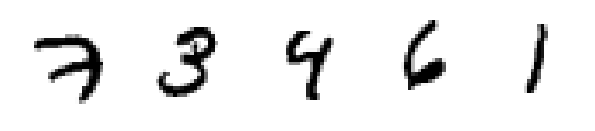

In [24]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [25]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
# 32 maps of 6x6 capsules each, each capsule outputting a vector of size 8, 36 vectors of size 8 in total

caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [26]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector
      
      

In [27]:
# Parameters for Primary Capsules
output_vec_no  = 32
output_vect_length = 8
caps_dims = 6

#Parameters for digital Capsules

digital_cap_no = 10
digital_cap_dim = 16


# Taking as an input the pictures, and outputing 32 vectors of length 8 for each of the inputs 
def primarycapsule(output_vec_no, output_vect_length, cap_dims, X):
  # Two convolutional layers followed by a reshape and squash:
  
    first_layer = tf.layers.conv2d(X, filters=256, kernel_size=9,
                                   padding='VALID', 
                                   strides=1, 
                                   activation=tf.nn.relu,
                                   name='first_layer')
    second_layer = tf.layers.conv2d(first_layer, filters=output_vec_no * output_vect_length,
                                    kernel_size = 9, padding = "VALID", strides = 2, activation = tf.nn.relu, name = "secondLayer")

    caps = tf.reshape(second_layer, [-1, output_vec_no * cap_dims * cap_dims, output_vect_length])

    caps = squash(caps)

    return caps


In [28]:

# Function Under Construction
def digitalcapsule(primary_out, digital_cap_no, digital_cap_dim):
  
    W_init = tf.random_normal(shape=(1, output_vec_no * caps_dims * caps_dims, digital_cap_no, digital_cap_dim, output_vect_length),stddev=0.1, dtype=tf.float32, name="W_init")
    # Register as variable
    W = tf.Variable(W_init, name="W")

    batch_size = tf.shape(X)[0]
    # lets you create an array containing many copies of a base array
    W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

    # Inserts a dimension of 1 into a tensor's shape.
    primaryCapsOutput_Expanded = tf.expand_dims(primary_out, -1,name="caps1_output_expanded")
    primaryCapsOutput_Tile = tf.expand_dims(primaryCapsOutput_Expanded, 2,name="caps1_output_tile")
    primaryCapsOutput_Tiled = tf.tile(primaryCapsOutput_Tile, [1, 1, digital_cap_no, 1, 1],name="caps1_output_tiled")

    print(W_tiled.shape) # ?, 1152, 10, 16, 8) dtype=float32>
    print(primaryCapsOutput_Tiled.shape) # (?, 1152, 10, 8, 1) dtype=float32>

    digitCapsulesPrediction = tf.matmul(W_tiled, primaryCapsOutput_Tiled,name="caps2_predicted")  
    print(digitCapsulesPrediction.shape)

    return digitCapsulesPrediction


primarycaps = primarycapsule(output_vec_no, output_vect_length, caps_dims, X)
print(primarycaps.shape)
digitalcaps = digitalcapsule(primarycaps, digital_cap_no, digital_cap_dim)

(?, 1152, 8)
(?, 1152, 10, 16, 8)
(?, 1152, 10, 8, 1)
(?, 1152, 10, 16, 1)


In [29]:
# ROUTING BY AGREEMENT CELL 



# first routing by agreement function, multiply weights with outputs, then sum 
def routing_1(batch_size, digitCapsules):
    # initalizing the weights with zeroes

    initialWeights = tf.zeros([batch_size, caps1_n_caps, digital_cap_no, 1, 1], dtype=np.float32, name="initialWeights")

    # Applying the softmax on the initial weights
    routingWeights = tf.nn.softmax(initialWeights, dim=2, name="routingWeights")

    # Compute the weighted sum:

    # We first multiply the weights with the output of the last capsule:
    routingPrediction = tf.multiply(routingWeights, digitCapsules,name="weighted_predictions")

    # The we do the sum:
    routingSum = tf.reduce_sum(routingPrediction, axis=1, keep_dims=True,name="routingSum")

    # applying squash function
    digitCapsulesOutput = squash(routingSum, axis=-2,name="caps2_output_round_1")

    return digitCapsulesOutput, initialWeights

    return 0


def routing_2(initialWeights, digitCapsulesOutput, digitCapsulesPrediction):

    # duplicating the number of each output per primary capsules to primaryCapsules.size to prepare the multiplication 
    digitCapsulesOutput_Tiled = tf.tile(digitCapsulesOutput, [1, caps1_n_caps, 1, 1, 1],name="caps2_output_round_1_tiled")

    # Multipliyng

    routingAgreement = tf.matmul(digitCapsulesPrediction, digitCapsulesOutput_Tiled,
                      transpose_a=True, name="agreement")


    # adding the agreement update to the initial weights before softmax (used in previous round)
    raw_weights_round_2 = tf.add(initialWeights, routingAgreement,name="raw_weights_round_2")


    # Rest is like round 1, multiply by weights, sum and squash

    routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,dim=2,name="routing_weights_round_2")
    weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, digitCapsulesOutput, name="weighted_predictions_round_2")
    weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keep_dims=True,  name="weighted_sum_round_2")
    caps2_output_round_2 = squash(weighted_sum_round_2,axis=-2,name="caps2_output_round_2")

    return caps2_output_round_2


# routing by agreement calls 
batch_sizes = tf.shape(X)[0]
digitCapsOutput, initWeights = routing_1(batch_sizes, digitalcaps)
caps2_output = routing_2(initWeights, digitCapsOutput, digitalcaps)

In [30]:
# Normalize class probabilities, but do it safely like with the squash as we can get a division by 0
def safe_normalize(probabilities, axis=-1, eps=1e-7, keepDimensions=False, name=None):
    with tf.name_scope(name, default_name='safeNormalize'):
        squaredProbabilities = tf.reduce_sum(tf.square(probabilities),axis=axis, keep_dims=keepDimensions)
        sqrtVal = tf.sqrt(squaredProbabilities + eps)
        return sqrtVal
  
def getPrediction(routingInput):
    # Find the predicted index
    y_hat_index = tf.argmax((safe_normalize(routingInput, axis=-2, name="y_hat")), axis=2, name="y_proba")

    # Remove 
    yPrediction = tf.squeeze(y_hat_index, axis=[1,2], name="y_pred")
    return yPrediction


y_predict = getPrediction(caps2_output)

In [31]:

yLabel = tf.placeholder(shape=[None], dtype=tf.int64, name="yLabel")

# Margin loss
def margin_loss(routingInput, mPlus = 0.9, mMinus = 0.1, lambdaVal = 0.5):

    # One hot representation of classes
    Tk = tf.one_hot(yLabel, depth=10, name="T")

    caps2_norm = safe_normalize(routingInput, axis=-2, name="y_hat")

    # Find error for both agreeing classes and disagreeing classes on same image
    correctPlacementError = tf.reshape(tf.square(tf.maximum(0.0,mPlus-caps2_norm)),  shape=(-1, 10), name="correctPlaceError")
    disPlacementError = tf.reshape(tf.square(tf.maximum(0.0,caps2_norm-mMinus)),  shape=(-1, 10), name="disPlaceError")

    #Compute loss for each digit
    loss = tf.add(Tk * correctPlacementError, lambdaVal * (1.0-Tk) * disPlacementError, name="customLoss")

    marginLoss = tf.reduce_mean(tf.reduce_sum(loss, axis=1), name="marginLoss")
    return marginLoss



In [32]:
 print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                          50, 1,
                          50 * 100 / 1,
                          0.5))
    
 print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                          50, 1,
                          50 * 100 / 1,
                          0.5))

Iteration: 50/1 (5000.0%)  Loss: 0.50000
Iteration: 50/1 (5000.0%)  Loss: 0.50000


In [33]:
# LOGITS
correct = tf.equal(yLabel, y_predict, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")


customLoss = margin_loss(caps2_output)
optimizer = tf.train.AdamOptimizer()
training = optimizer.minimize(customLoss, name="training_op")
init = tf.global_variables_initializer()

# TRAINER



epochs = 3

batchSize = 50
nBatches =  mnist.train.num_examples // batchSize
nBatches_validation = mnist.validation.num_examples // batchSize

printMsg_lossTrain = []
printMsg_accTrain = []



with tf.Session() as sess:
    init.run()

    for epoch in range(epochs):
        for batch in range (nBatches):
          xInput, yInput = mnist.train.next_batch(batchSize)
          # Reshape to img
          xInput = xInput.reshape([-1, 28, 28, 1])
          _, trainingLoss = sess.run([training,customLoss], feed_dict={X: xInput, yLabel: yInput, })
          print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                          batch, nBatches,
                          batch * 100 / nBatches,
                          trainingLoss, end=""))


    # End of training loop, measure accuracy on validation set
    loss_vals = []
    acc_vals = []
    for batch in range(1, nBatches_validation + 1):
        xInput, yInput = mnist.validation.next_batch(batchSize)
        xInput = xInput.reshape([-1, 28, 28, 1])
        loss_val, acc_val = sess.run(
                [loss, accuracy],
                feed_dict={X: xInput,
                           y: yInput})

        loss_vals.append(loss_val)
        acc_vals.append(acc_val)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(batch, nBatches_validation,batch * 100 / nBatches_validation))
    loss_val = np.mean(loss_vals)
    acc_val = np.mean(acc_vals)
    
    printMsg_lossTrain.append(loss_val)
    printMsg_accTrain.append(acc_val)

    print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(epoch + 1, acc_val * 100, loss_val," (improved)" if loss_val < best_loss_val else ""))


Iteration: 0/1100 (0.0%)  Loss: 0.80940
Iteration: 1/1100 (0.1%)  Loss: 3.60319
Iteration: 2/1100 (0.2%)  Loss: 3.16828
Iteration: 3/1100 (0.3%)  Loss: 0.67661
Iteration: 4/1100 (0.4%)  Loss: 0.76622
Iteration: 5/1100 (0.5%)  Loss: 0.69823
Iteration: 6/1100 (0.5%)  Loss: 0.77993
Iteration: 7/1100 (0.6%)  Loss: 0.73408
Iteration: 8/1100 (0.7%)  Loss: 0.78135
Iteration: 9/1100 (0.8%)  Loss: 0.77944
Iteration: 10/1100 (0.9%)  Loss: 0.76100
Iteration: 11/1100 (1.0%)  Loss: 0.70351
Iteration: 12/1100 (1.1%)  Loss: 0.64592
Iteration: 13/1100 (1.2%)  Loss: 0.59800
Iteration: 14/1100 (1.3%)  Loss: 0.59656
Iteration: 15/1100 (1.4%)  Loss: 0.46559
Iteration: 16/1100 (1.5%)  Loss: 0.65094
Iteration: 17/1100 (1.5%)  Loss: 0.56323
Iteration: 18/1100 (1.6%)  Loss: 0.69559
Iteration: 19/1100 (1.7%)  Loss: 0.69847
Iteration: 20/1100 (1.8%)  Loss: 0.62548
Iteration: 21/1100 (1.9%)  Loss: 0.42737
Iteration: 22/1100 (2.0%)  Loss: 0.47385
Iteration: 23/1100 (2.1%)  Loss: 0.60070
Iteration: 24/1100 (2.2%) 

KeyboardInterrupt: 

In [ ]:
print("bla")